# Investigation of the numpy.random package

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.stats import binom
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" ## Ref [] to display all called variables in a cell
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [2]:
specialA = np.random.randint(0, 31, size=6)
specialB = np.random.randint(0, 31, size=6)

totA = sum(specialA)
totB = sum(specialB)


#while totA != 33:
#    specialA = np.random.randint(1, 11, size=7)    
#    totA = sum(specialA)
    
    
#while totB != 33:    
#    specialB = np.random.randint(1, 11, size=7)   
#    totB = sum(specialB)

specialA
specialB
totA
totB

array([ 7,  7, 27, 14, 22,  7])

array([18,  1, 26, 27, 21, 26])

84

119

In [3]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta



In [4]:
def character_data():
    data = [
        ['HP', 'Attack', 'Defence', 'Sp. Attack', 'Sp. Defence', 'Speed'],
        ('Charmander A', [
            np.random.randint(0, 31, size=6)]),
        ('Charmander B', [
            np.random.randint(0, 31, size=6)]),
]
    return data


Text(0.5, 1.15, 'Charmander A')

Text(0.5, 1.15, 'Charmander B')

Text(0.5, 0.7, 'Character SPECIAL Parameters')

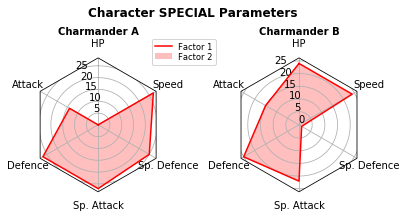

In [24]:
def character_data():
    data = [
        ['HP', 'Attack', 'Defence', 'Sp. Attack', 'Sp. Defence', 'Speed'],
        ('Charmander A', [
            np.random.randint(0, 31, size=6)]),
        ('Charmander B', [
            np.random.randint(0, 31, size=6)]),
]
    return data

if __name__ == '__main__':
    N = 6
    theta = radar_factory(N, frame='polygon')

    data = character_data()
    spoke_labels = data.pop(0)

    fig, axes = pl.subplots(figsize=(6, 6), ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)

    colors = ['r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flat, data):
       # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.15),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    ax = axes[0]
    labels = ('Factor 1', 'Factor 2',)
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.7, 'Character SPECIAL Parameters',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    pl.show()

## Problem 1: Overall package purpose

Random number generators (RNG) in computing are used to generate pseudonrandom numbers for use in things like statistical sampling, cryptography and procedural generation.

"True" random numbers stem from analysis of an entropic systems such as, in the case of a computer, fan heat or the timing of keyboard pressing  [ref], which are considered disordered and unpredictable. This is in contrast with the pseudorandom numbers generated by algorithms, such as the one used in the numpy.random package. This package produces a sequence of seemingly random numbers which are in reality predetermined by a defining attribute known as a key, or seed, upon initialisation.



In [6]:
5 * np.random.random_sample((3, 2)) 

array([[1.24602579, 0.33578057],
       [0.03989331, 1.23562004],
       [2.72121259, 1.29567195]])

## Problem 2: Simple Random Data and Permutations

### numpy.random.rand

Random values in the interval [0, 1)

(array([ 99.,  83., 134.,  82., 111.,  96., 106.,  97.,  99.,  93.]),
 array([4.22953374e-04, 1.00363879e-01, 2.00304804e-01, 3.00245730e-01,
        4.00186655e-01, 5.00127581e-01, 6.00068506e-01, 7.00009432e-01,
        7.99950357e-01, 8.99891283e-01, 9.99832208e-01]),
 <a list of 10 Patch objects>)

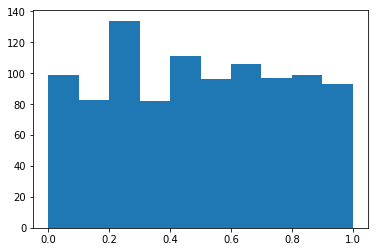

In [7]:
x = np.random.rand(1000)
pl.hist(x)

### numpy.random.randn¶

Random sample of normal/Gaussian distribution

In [8]:
np.random.randn()

0.8637724065291912

In [9]:
2.5 * np.random.randn(2, 4) + 3

array([[ 0.51231993,  5.75591133,  5.0026865 ,  5.40848195],
       [-1.48112417, -1.87823331,  3.73573374,  2.25214381]])

### numpy.random.randint
Random integers

In [10]:
np.random.randint(2, size=10)

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0])

In [11]:
np.random.randint(1, size=10)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
th = np.random.randint(0, 20, size=(10))
th

array([11, 12,  9,  4, 11, 18,  7, 11,  5,  5])

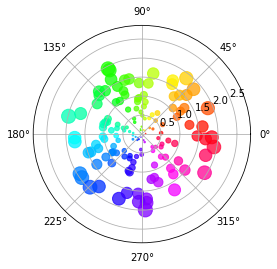

In [13]:
N = 150
r = 2 * np.random.rand(N)
theta = 2 * np.pi * np.random.rand(N)
area = 50 * r**2
colors = theta

fig = pl.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=0.75)

### Permutation

Permutations are arrangements of a set of values in a certain sequence or pattern, without repeating e.g a deck of cards.

In [14]:
np.random.permutation(10)
np.random.permutation([1, 4, 9, 12, 15])
arr = np.arange(9).reshape((3, 3))
np.random.permutation(arr)


array([9, 0, 2, 3, 4, 5, 8, 7, 1, 6])

array([15,  9,  4, 12,  1])

array([[3, 4, 5],
       [6, 7, 8],
       [0, 1, 2]])

## Problem 3: Distributions

### Pareto

The 80-20 rule (sociology, economics etc.)

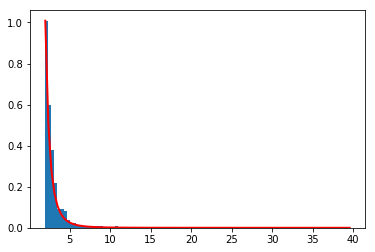

In [15]:
a, m = 3., 2.  # shape and mode
s = (np.random.pareto(a, 1000) + 1) * m
count, bins, _ = pl.hist(s, 100, density=True)
fit = a*m**a / bins**(a+1)
pl.plot(bins, max(count)*fit/max(fit), linewidth=2, color='r')
pl.show()

### Laplace
E.g. Rainfall




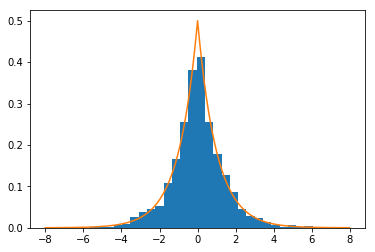

In [16]:
loc, scale = 0., 1.
s = np.random.laplace(loc, scale, 1000)
count, bins, ignored = pl.hist(s, 30, density=True)
x = np.arange(-8., 8., .01)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
pl.plot(x, pdf)

### Binomial 

Probability of events with only two outcomes, yes or no e.g. flipping a coin

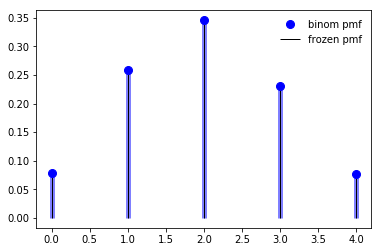

In [17]:
fig, ax = pl.subplots(1, 1)
n, p = 5, 0.4
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')
x = np.arange(binom.ppf(0.01, n, p),
              binom.ppf(0.99, n, p))
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)
rv = binom(n, p)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
        label='frozen pmf')
ax.legend(loc='best', frameon=False)
pl.show()

### Poisson

Probability of events occuring if a constant rate is known and is independent of previous event e.g. phone calls, website crashes [ref]

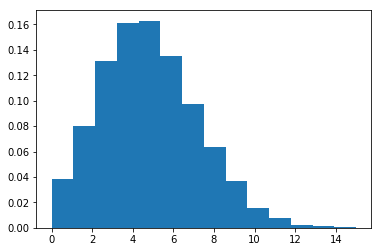

In [18]:
s = np.random.poisson(5, 10000)
count, bins, ignored = pl.hist(s, 14, density=True)
x = np.arange(0., 16., .01)
pl.show()

### Normal / Gaussian

A.K.A. the Bell Curve

Follows the formula: 

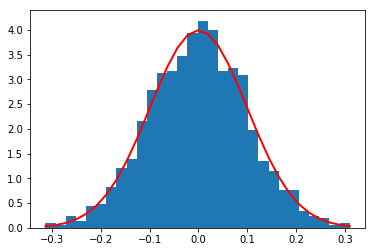

In [19]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = pl.hist(s, 30, density=True)
pl.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
pl.show()

## Problem 4: Seeds

Seeds are an attribute of random number generators decided at the time of import/initialisation. They determine the pattern which the "random" numbers will materialise. If the generator is initialized with the same seed in multiple instances, it will produce the same sequence of numbers each time, in adherence with various probability distributions. This is demonstrated below with the numpy.random.seed function used to set the seed.

In [20]:
x1 = np.random.randn(3, 3)
y1 = np.random.randn(3, 3)
x1
y1

array([[ 0.02955846,  1.16240853,  0.02245367],
       [ 0.90235966,  0.23586339,  1.35922608],
       [-0.57283753, -0.06571875, -0.71333604]])

array([[-0.7006218 ,  0.12446148,  0.73857979],
       [ 0.51497711, -1.27860348, -1.38810202],
       [-0.03421788, -1.25700111, -1.91206586]])

In [21]:
np.random.seed(12)
x2 = np.random.randn(3, 3)
np.random.seed(12)
y2 = np.random.randn(3, 3)
x2
y2

array([[ 0.47298583, -0.68142588,  0.2424395 ],
       [-1.70073563,  0.75314283, -1.53472134],
       [ 0.00512708, -0.12022767, -0.80698188]])

array([[ 0.47298583, -0.68142588,  0.2424395 ],
       [-1.70073563,  0.75314283, -1.53472134],
       [ 0.00512708, -0.12022767, -0.80698188]])

The function numpy.random.randomstate can take a seed as a parameter. 

In [22]:
state = np.random.RandomState(12)
state.randn(3, 3)
state = np.random.RandomState(12)
state.randn(3, 3)
state.randn(3, 3)

array([[ 0.47298583, -0.68142588,  0.2424395 ],
       [-1.70073563,  0.75314283, -1.53472134],
       [ 0.00512708, -0.12022767, -0.80698188]])

array([[ 0.47298583, -0.68142588,  0.2424395 ],
       [-1.70073563,  0.75314283, -1.53472134],
       [ 0.00512708, -0.12022767, -0.80698188]])

array([[ 2.87181939, -0.59782292,  0.47245699],
       [ 1.09595612, -1.2151688 ,  1.34235637],
       [-0.12214979,  1.01251548, -0.91386915]])

# References

https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs

https://www.howtogeek.com/183051/htg-explains-how-computers-generate-random-numbers/ - randomness/entropy etc.

https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459